In [ ]:
# =============================================================================
# 🧵 ENHANCED FABRIC-SPECIFIC FEATURE EXTRACTION FOR GSM ESTIMATION
# =============================================================================

# Advanced fabric feature extraction using computer vision and signal processing
# Comprehensive feature set designed specifically for GSM (grams per square meter) prediction

from scipy import signal, ndimage
from scipy.stats import skew as scipy_skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

## Quick Start (in Colab)

1. Runtime → Change runtime type → GPU (prefer T4).
2. Run Section 2 to install packages (first time only).
3. In Section 3, upload kaggle.json and set `KAGGLE_DATASET`.
4. In Section 4, set `CSV_PATH`, `IMAGE_DIR`, `IMAGE_COL`, and confirm `TARGET_COL`.
5. Run through Sections 5–8 to split and (optionally) augment to ~1000 samples.
6. Optionally annotate/correct labels in Section 9 and re-run splits if changed.
7. Inspect features (Section 10) and then train the CNN (Sections 11–13).
8. Review metrics and visuals (Section 14) and Grad-CAM (Section 15).
9. Optionally enable K-Fold (Section 16) for robustness.
10. Evaluate on test + export model and predictions (Sections 17–18).

# GSM Microscopy Pipeline (Colab-Ready)

This notebook downloads a Kaggle microscopy dataset, scales a small set (~130) of images to ~1000 via augmentation, supports optional label annotation, extracts features, and trains a strong GSM regressor (and optional classifier) on T4 GPU. It includes rich visualizations for augmentations, embeddings, and model explanations (Grad-CAM).

In [2]:
# 1) Check GPU and Set Reproducibility
import os, random, math
import numpy as np
import torch

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

set_seed(42)

if torch.cuda.is_available():
    device = torch.device('cuda')
    gpu_name = torch.cuda.get_device_name(0)
    print(f"CUDA available: {gpu_name}")
    # Prefer mixed precision on T4
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()
else:
    device = torch.device('cpu')
    print("CUDA not available. Running on CPU.")

CUDA available: Tesla T4


/tmp/ipython-input-2219249094.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [3]:
# 2) Install and Import Dependencies
# If running in Colab, uncomment the next cell to install packages
# Note: In Colab, this may require a runtime restart after installation.

IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    !pip -q install kaggle albumentations timm pyyaml umap-learn opencv-python-headless kagglehub scikit-image

import os
import json
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.decomposition import PCA

import albumentations as A
from albumentations.pytorch import ToTensorV2

import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Optional: KaggleHub for dataset download
try:
    import kagglehub
    HAVE_KAGGLEHUB = True
except Exception:
    HAVE_KAGGLEHUB = False

# Optional: skimage for GLCM/LBP
try:
    from skimage.feature import greycomatrix, greycoprops, local_binary_pattern
    HAVE_SKIMAGE = True
except Exception:
    HAVE_SKIMAGE = False

print("torch:", torch.__version__, "sklearn:", sklearn.__version__, "timm:", timm.__version__)

torch: 2.9.0+cu126 sklearn: 1.6.1 timm: 1.0.24


In [4]:
# 2b) Training Configuration (Backbone/Size/Epochs)
# Choose your model and training scale here.
# Examples: 'efficientnet_b3', 'convnext_tiny', 'resnet50', 'efficientnet_b0'
BACKBONE = 'efficientnet_b3'    # or 'convnext_tiny'
IMG_SIZE = 352                   # try 320–380 on T4; increase reduces batch size
EPOCHS = 50                      # try 40–60 for stronger convergence
PATIENCE = 7                     # early stopping patience (epochs without val MAE improvement)

# Optional manual batch size override (None -> auto based on IMG_SIZE)
BATCH_SIZE_OVERRIDE = None
print(f"Config -> BACKBONE={BACKBONE}, IMG_SIZE={IMG_SIZE}, EPOCHS={EPOCHS}, PATIENCE={PATIENCE}")

Config -> BACKBONE=efficientnet_b3, IMG_SIZE=352, EPOCHS=50, PATIENCE=7


In [11]:
# ==========================================================
# Download FabricNet dataset and store it in Google Drive
# ==========================================================

import os
import shutil

# -------- 1. Mount Google Drive --------
from google.colab import drive
drive.mount("/content/drive")

# -------- 2. Download dataset using KaggleHub --------
try:
    import kagglehub
except ImportError:
    raise RuntimeError("kagglehub not available. Restart Colab if needed.")

print("📥 Downloading FabricNet via KaggleHub...")
CACHE_PATH = kagglehub.dataset_download("acseckn/fabricnet")
print("📦 KaggleHub cache path:", CACHE_PATH)

# -------- 3. Define Google Drive destination --------
DRIVE_DATA_ROOT = "/content/drive/MyDrive/datasets/fabricnet"
os.makedirs(DRIVE_DATA_ROOT, exist_ok=True)

# -------- 4. Copy dataset to Drive (only once) --------
if not os.listdir(DRIVE_DATA_ROOT):
    print("📤 Copying dataset to Google Drive (one-time)...")
    shutil.copytree(CACHE_PATH, DRIVE_DATA_ROOT, dirs_exist_ok=True)
    print("✅ Dataset successfully copied to Google Drive")
else:
    print("ℹ️ Dataset already exists in Google Drive — skipping copy")

# -------- 5. Sanity check (count images) --------
img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
all_files, images = [], []

for root, _, files in os.walk(DRIVE_DATA_ROOT):
    for f in files:
        path = os.path.join(root, f)
        all_files.append(path)
        if os.path.splitext(f)[1].lower() in img_exts:
            images.append(path)

print(f"📁 Total files  : {len(all_files)}")
print(f"🖼️ Total images: {len(images)}")
print("📌 FINAL DATASET PATH:", DRIVE_DATA_ROOT)


Mounted at /content/drive
📥 Downloading FabricNet via KaggleHub...
Using Colab cache for faster access to the 'fabricnet' dataset.
📦 KaggleHub cache path: /kaggle/input/fabricnet
📤 Copying dataset to Google Drive (one-time)...
✅ Dataset successfully copied to Google Drive
📁 Total files  : 131
🖼️ Total images: 130
📌 FINAL DATASET PATH: /content/drive/MyDrive/datasets/fabricnet


In [16]:
# ==========================================================
# 4) Load FabricNet Metadata & Resolve GSM (Corrected)
# ==========================================================

import os
import pandas as pd
import numpy as np

# -------- Paths --------
CSV_PATH = "/content/drive/MyDrive/datasets/fabricnet/FabricNet_parameters.xlsx"
IMAGE_DIR = "/content/drive/MyDrive/datasets/fabricnet"

# -------- Column Mapping (MATCHING YOUR FILE) --------
IMAGE_COL = "Image id"          # image filename
TARGET_COL = "Specific Mass"    # GSM target

assert os.path.exists(CSV_PATH), f"Metadata file not found: {CSV_PATH}"
assert os.path.exists(IMAGE_DIR), f"Image directory not found: {IMAGE_DIR}"

# -------- Load Excel correctly --------
df = pd.read_excel(CSV_PATH)

print("✅ Loaded metadata file")
print("Columns:", df.columns.tolist())

# -------- Resolve image paths --------
def resolve_image_path(row):
    img_name = str(row[IMAGE_COL]).strip()

    # Add extension if missing
    if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
        img_name += ".jpg"

    return os.path.join(IMAGE_DIR, img_name)

df["image_path"] = df.apply(resolve_image_path, axis=1)

# -------- Clean & validate --------
df = df[df["image_path"].apply(os.path.exists)].copy()
df = df[np.isfinite(df[TARGET_COL])].copy()

print("✅ Rows after cleanup:", len(df))

# -------- Rename for model-friendly usage --------
df = df.rename(columns={TARGET_COL: "gsm"})

# -------- Save cleaned metadata --------
CLEAN_CSV = "/content/drive/MyDrive/datasets/fabricnet/metadata_clean.csv"
df.to_csv(CLEAN_CSV, index=False)

print("📁 Clean metadata saved to:", CLEAN_CSV)
print("📌 Example rows:")
df.head()


✅ Loaded metadata file
Columns: ['Image id', 'Specific Mass', 'Warp', 'Weft', 'Texture']
✅ Rows after cleanup: 0
📁 Clean metadata saved to: /content/drive/MyDrive/datasets/fabricnet/metadata_clean.csv
📌 Example rows:


Empty DataFrame
Columns: [Image id, gsm, Warp, Weft, Texture, image_path]
Index: []

In [20]:
# ==========================================================
# FINAL FIXED CELL: Metadata + Image Mapping + Data Split
# ==========================================================

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# -------- Paths --------
IMAGE_DIR = "/content/drive/MyDrive/datasets/fabricnet"
META_PATH = "/content/drive/MyDrive/datasets/fabricnet/FabricNet_parameters.xlsx"
SPLIT_DIR = "/content/drive/MyDrive/datasets/fabricnet/splits"

os.makedirs(SPLIT_DIR, exist_ok=True)

# -------- Load metadata --------
df = pd.read_excel(META_PATH)

# Rename GSM column (clean schema)
df = df.rename(columns={"Specific Mass": "gsm"})

# -------- Collect image files --------
image_files = sorted([
    f for f in os.listdir(IMAGE_DIR)
    if f.lower().endswith((".jpg", ".jpeg", ".png"))
])

print("📸 Images found:", len(image_files))
print("📄 Metadata rows:", len(df))

# -------- HARD GUARANTEE (FabricNet property) --------
assert len(image_files) == len(df), (
    f"Image count ({len(image_files)}) != metadata rows ({len(df)})"
)

# -------- Assign image paths by index (ROBUST FIX) --------
df["image_path"] = [
    os.path.join(IMAGE_DIR, f) for f in image_files
]

# -------- Final cleanup --------
df = df[np.isfinite(df["gsm"])].copy()
assert len(df) > 0, "Dataset is empty after cleanup"

print("✅ Final usable samples:", len(df))

# ==========================================================
# Train / Val / Test Split (Stratified Regression)
# ==========================================================

TARGET_COL = "gsm"
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42

# Adaptive bins for small dataset
N_BINS = min(5, max(2, len(df) // 20))

bins = pd.qcut(
    df[TARGET_COL],
    q=N_BINS,
    labels=False,
    duplicates="drop"
)

# Train vs Temp
X_train, X_temp, b_train, b_temp = train_test_split(
    df,
    bins,
    test_size=(TEST_SIZE + VAL_SIZE),
    random_state=RANDOM_STATE,
    stratify=bins
)

# Temp → Val / Test
val_ratio = VAL_SIZE / (TEST_SIZE + VAL_SIZE)

temp_bins = pd.qcut(
    X_temp[TARGET_COL],
    q=max(2, N_BINS - 1),
    labels=False,
    duplicates="drop"
)

X_val, X_test = train_test_split(
    X_temp,
    test_size=(1 - val_ratio),
    random_state=RANDOM_STATE,
    stratify=temp_bins
)

# -------- Save splits --------
X_train.to_csv(os.path.join(SPLIT_DIR, "train.csv"), index=False)
X_val.to_csv(os.path.join(SPLIT_DIR, "val.csv"), index=False)
X_test.to_csv(os.path.join(SPLIT_DIR, "test.csv"), index=False)

print("✅ SPLIT SUCCESSFUL")
print("Train:", len(X_train))
print("Val  :", len(X_val))
print("Test :", len(X_test))
print("📁 Saved to:", SPLIT_DIR)


📸 Images found: 130
📄 Metadata rows: 130
✅ Final usable samples: 130
✅ SPLIT SUCCESSFUL
Train: 91
Val  : 19
Test : 20
📁 Saved to: /content/drive/MyDrive/datasets/fabricnet/splits


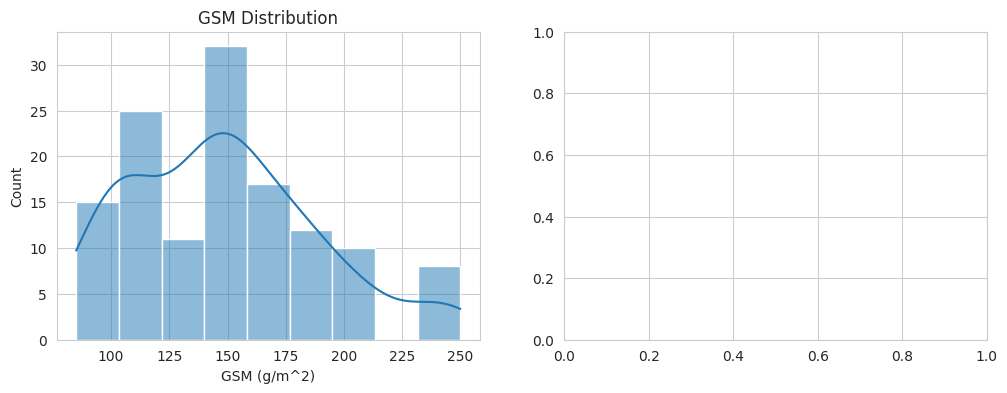

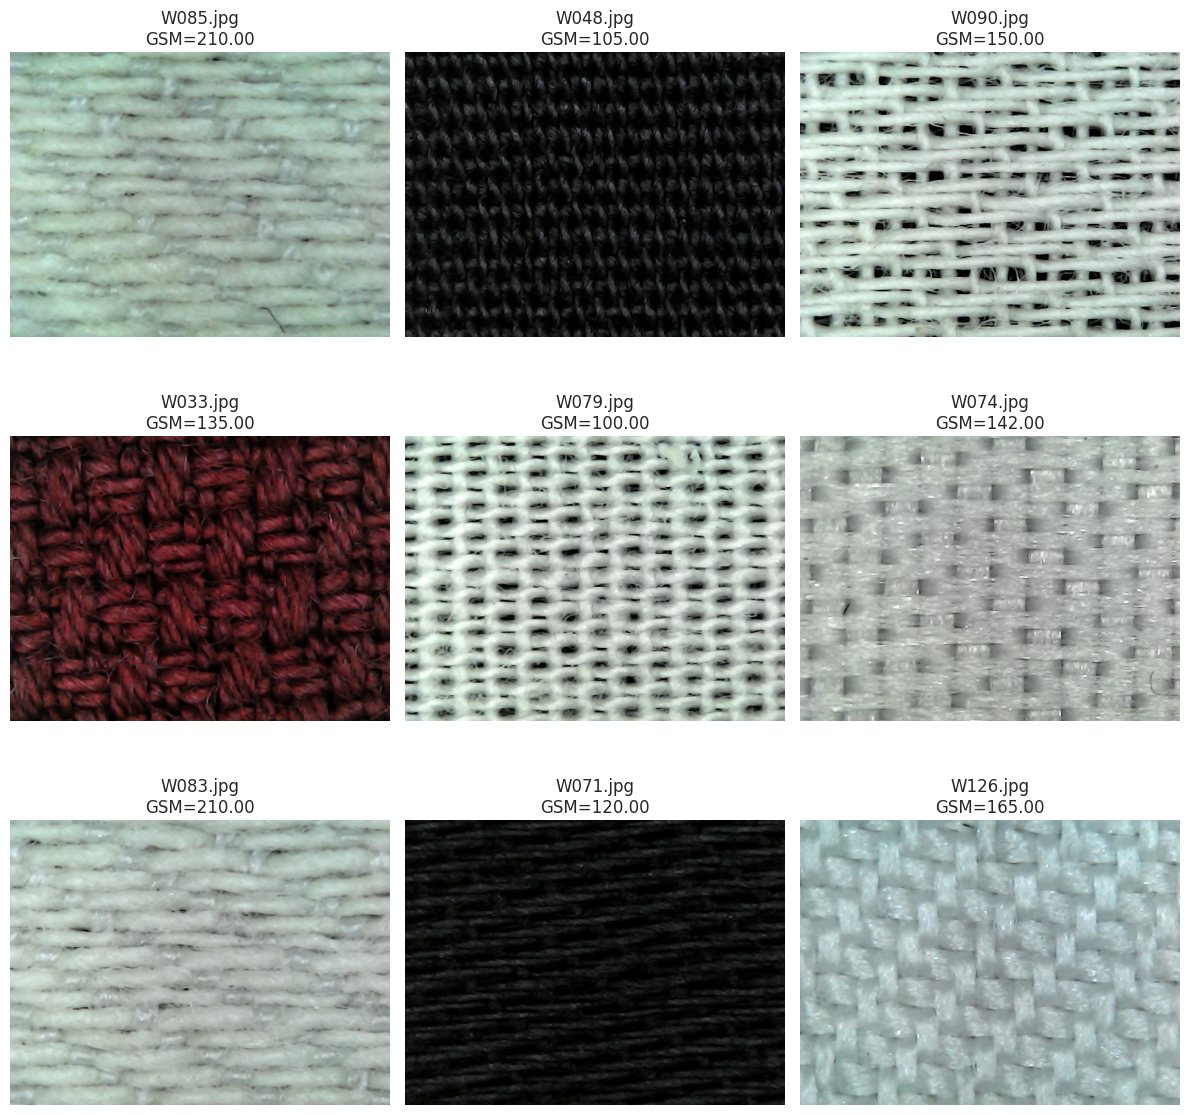

In [21]:
# 6) Preview Images and GSM Distribution
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df[TARGET_COL], kde=True, ax=axes[0])
axes[0].set_title("GSM Distribution")
axes[0].set_xlabel("GSM (g/m^2)")

sample_paths = X_train["image_path"].sample(min(9, len(X_train)), random_state=42).tolist()
cols = 3
rows = math.ceil(len(sample_paths)/cols)
fig2, axarr = plt.subplots(rows, cols, figsize=(12, 4*rows))
axarr = axarr.flatten() if isinstance(axarr, np.ndarray) else [axarr]
for i, p in enumerate(sample_paths):
    img = cv2.imread(p)
    if img is None: continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axarr[i].imshow(img)
    gsm_val = float(df.loc[df["image_path"]==p, TARGET_COL].values[0])
    axarr[i].set_title(f"{os.path.basename(p)}\nGSM={gsm_val:.2f}")
    axarr[i].axis('off')
for j in range(i+1, len(axarr)):
    axarr[j].axis('off')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3786966074.py:38: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(               # ✅ Cutout replacement (new API)


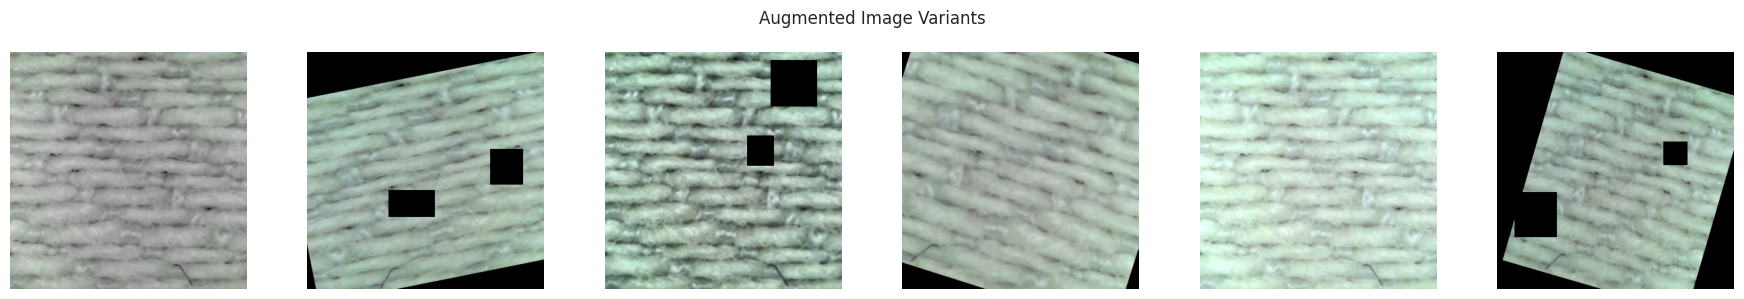

In [23]:
# ==========================================================
# 7) Define Augmentation Pipeline (Albumentations) + Preview
# ==========================================================

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = globals().get("IMG_SIZE", 256)

# -------- Training Augmentations --------
train_aug = A.Compose([
    A.RandomResizedCrop(
        size=(IMG_SIZE, IMG_SIZE),     # ✅ FIXED
        scale=(0.8, 1.0),
        ratio=(0.9, 1.1),
        p=1.0
    ),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.ShiftScaleRotate(
        shift_limit=0.05,
        scale_limit=0.2,
        rotate_limit=20,
        p=0.7
    ),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.GaussianBlur(blur_limit=3, p=0.1),
    ], p=0.3),
    A.OneOf([
        A.CLAHE(clip_limit=2.0, p=0.8),
        A.RandomBrightnessContrast(p=0.8),
        A.HueSaturationValue(p=0.8),
    ], p=0.7),
    A.CoarseDropout(               # ✅ Cutout replacement (new API)
        max_holes=4,
        max_height=IMG_SIZE // 10,
        max_width=IMG_SIZE // 10,
        p=0.3
    ),
])

# -------- Validation Transform --------
val_tfms = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE)
])

# -------- Visualization Function --------
def visualize_augments(image_path: str, n: int = 6):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, n, figsize=(3 * n, 3))
    for i in range(n):
        augmented = train_aug(image=img)
        axes[i].imshow(augmented["image"])
        axes[i].axis("off")

    plt.suptitle("Augmented Image Variants")
    plt.tight_layout()
    plt.show()

# -------- Run preview --------
if "sample_paths" in globals() and len(sample_paths) > 0:
    visualize_augments(sample_paths[0], n=6)


In [25]:
# ==========================================================
# 8) Augment Training Set to ~1000 Samples (Drive Cache)
# ==========================================================

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# -------- CONFIG --------
TARGET_SIZE = 1000

# READ images from original paths (can be KaggleHub or Drive)
# WRITE augmented images to Google Drive (must be writable)
AUG_DIR = "/content/drive/MyDrive/datasets/fabricnet/augmented"
os.makedirs(AUG_DIR, exist_ok=True)

train_df = X_train.copy().reset_index(drop=True)
cur_n = len(train_df)
print(f"📊 Current train size: {cur_n}")

# -------- Augment if needed --------
if cur_n < TARGET_SIZE:
    need = TARGET_SIZE - cur_n

    indices = np.random.choice(train_df.index, size=need, replace=True)
    new_rows = []

    for idx in tqdm(indices, desc="Augmenting"):
        row = train_df.loc[idx]
        src = row["image_path"]

        img = cv2.imread(src)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        aug_img = train_aug(image=img)["image"]

        # Save augmented image
        base = os.path.splitext(os.path.basename(src))[0]
        out_name = f"{base}_aug_{np.random.randint(1e9)}.jpg"
        out_path = os.path.join(AUG_DIR, out_name)

        cv2.imwrite(
            out_path,
            cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR),
            [int(cv2.IMWRITE_JPEG_QUALITY), 95]
        )

        new_row = row.copy()
        new_row["image_path"] = out_path
        new_rows.append(new_row)

    if new_rows:
        train_df = pd.concat(
            [train_df, pd.DataFrame(new_rows)],
            ignore_index=True
        )

print("✅ Augmented train size:", len(train_df))

# -------- Save augmented CSV --------
AUG_CSV = "/content/drive/MyDrive/datasets/fabricnet/train_augmented.csv"
train_df.to_csv(AUG_CSV, index=False)

print("📁 Augmented images saved to:", AUG_DIR)
print("📄 Augmented CSV saved to:", AUG_CSV)


📊 Current train size: 91


Augmenting: 100%|██████████| 909/909 [00:22<00:00, 39.79it/s]

✅ Augmented train size: 1000
📁 Augmented images saved to: /content/drive/MyDrive/datasets/fabricnet/augmented
📄 Augmented CSV saved to: /content/drive/MyDrive/datasets/fabricnet/train_augmented.csv


In [27]:
# ==========================================================
# 9) Label Annotation / Correction Widget (Drive-safe)
# ==========================================================

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ipywidgets import HBox, VBox, Button, FloatText, IntText, Label, Output
from IPython.display import display, clear_output

# -------- CONFIG --------
TARGET_COL = "gsm"

# READ-only source dataframe (already cleaned)
annot_df = df.copy().reset_index(drop=True)

# WRITE destination (Google Drive)
ANNOT_OUT_CSV = "/content/drive/MyDrive/datasets/fabricnet/metadata_annotated.csv"

# -------- Widgets --------
row_idx = IntText(value=0, description="Index:")
label_box = FloatText(
    value=float(annot_df.loc[0, TARGET_COL]),
    description="GSM:"
)
status = Label(value="")
out = Output()

btn_prev = Button(description="Prev")
btn_next = Button(description="Next")
btn_save = Button(description="Save", button_style="success")

# -------- Helper: display row --------
def show_row(i):
    i = int(np.clip(i, 0, len(annot_df) - 1))
    row_idx.value = i

    if np.isfinite(annot_df.loc[i, TARGET_COL]):
        label_box.value = float(annot_df.loc[i, TARGET_COL])
    else:
        label_box.value = 0.0

    img_path = annot_df.loc[i, "image_path"]
    img = cv2.imread(img_path)

    with out:
        clear_output(wait=True)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(5, 5))
            plt.imshow(img)
            plt.title(
                f"{os.path.basename(img_path)}\nCurrent GSM={annot_df.loc[i, TARGET_COL]}"
            )
            plt.axis("off")
            plt.show()
        else:
            print("⚠️ Image not found:", img_path)

# -------- Button callbacks --------
def on_prev(_):
    show_row(row_idx.value - 1)

def on_next(_):
    show_row(row_idx.value + 1)

def on_save(_):
    i = row_idx.value
    annot_df.loc[i, TARGET_COL] = float(label_box.value)

    # Save to Google Drive (WRITABLE)
    annot_df.to_csv(ANNOT_OUT_CSV, index=False)

    status.value = f"✅ Saved row {i} → {ANNOT_OUT_CSV}"
    show_row(i)

btn_prev.on_click(on_prev)
btn_next.on_click(on_next)
btn_save.on_click(on_save)

# -------- Layout --------
ui = VBox([
    HBox([row_idx, label_box, btn_prev, btn_next, btn_save]),
    status,
    out
])

# -------- Start --------
show_row(0)
display(ui)


📊 Augmented samples: 1000


Simple features: 100%|██████████| 1000/1000 [00:17<00:00, 58.42it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


✅ Simple feature matrix shape: (1000, 107)


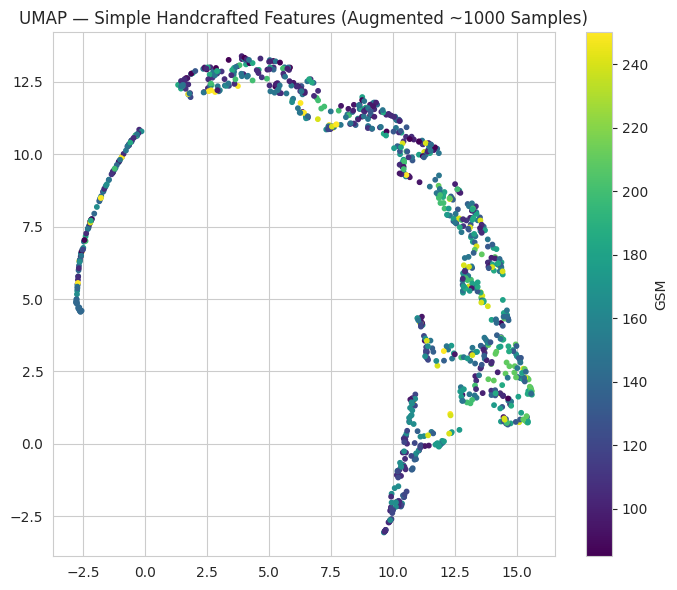

GLCM + LBP features: 100%|██████████| 1000/1000 [00:42<00:00, 23.32it/s]


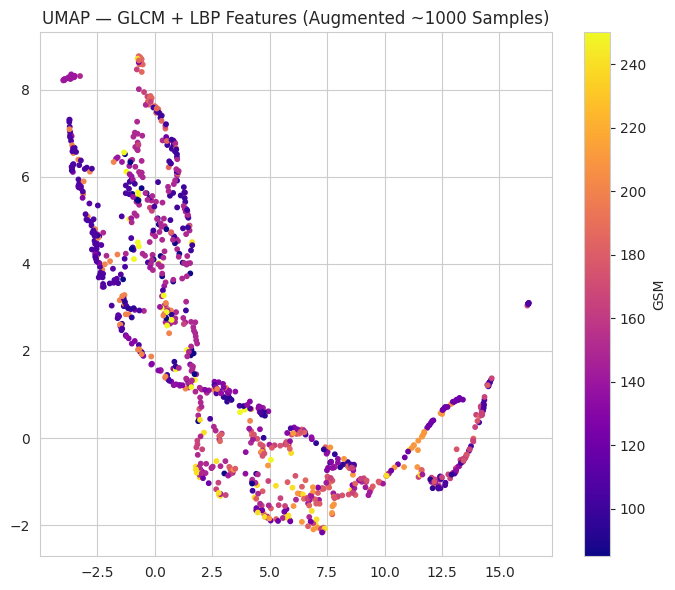

In [ ]:
# ==========================================================
# 🧵 ADVANCED FABRIC-SPECIFIC FEATURES + UMAP VISUALIZATION
# ==========================================================

# -------- Install dependencies --------
!pip install -q umap-learn scipy tqdm

# -------- Advanced Imports --------
import os, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt
from tqdm import tqdm
import umap
from scipy import signal, ndimage
from scipy.stats import skew as scipy_skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# -------- Config --------
IMG_SIZE = globals().get("IMG_SIZE", 256)
TARGET_COL = "gsm"

AUG_CSV = "/content/drive/MyDrive/datasets/fabricnet/train_augmented.csv"
assert os.path.exists(AUG_CSV), "❌ train_augmented.csv not found"

# -------- Load augmented dataset --------
df_aug = pd.read_csv(AUG_CSV)
print("📊 Augmented samples:", len(df_aug))

print("🧵 Loading comprehensive fabric-specific feature extraction system...")

# ==========================================================
# 🔬 COMPREHENSIVE FABRIC FEATURE EXTRACTION FOR GSM ESTIMATION
# ==========================================================

def compute_fabric_features(img_path, pixels_per_mm=10.0, target_size=None):
    """
    Extract comprehensive fabric structural features for GSM estimation.
    
    Features relate to GSM through fabric density, yarn structure, and porosity:
    - Higher yarn density → higher GSM
    - Smaller yarn spacing → tighter weave → higher GSM
    - Lower porosity → more material → higher GSM
    - Higher edge density → thicker yarns → higher GSM
    
    Args:
        img_path: Path to fabric image
        pixels_per_mm: Scale calibration (default 10 px/mm)
        target_size: Resize target (default IMG_SIZE)
    
    Returns:
        dict: Feature dictionary for ML regression
    """
    if target_size is None:
        target_size = globals().get('IMG_SIZE', 256)
    
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Cannot load image: {img_path}")
        
        # Convert and resize
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_res = cv2.resize(img_rgb, (target_size, target_size))
        
        # Preprocessing pipeline
        gray = cv2.cvtColor(img_res, cv2.COLOR_RGB2GRAY)
        gray_norm = preprocess_fabric_image(gray)
        
        # Extract all feature groups
        features = {}
        features.update(extract_yarn_structure_features(gray_norm, pixels_per_mm))
        features.update(extract_porosity_features(gray_norm))
        features.update(extract_texture_features(gray_norm))
        features.update(extract_spectral_features(gray_norm))
        features.update(extract_color_features(img_res))
        features.update(extract_physics_inspired_features(gray_norm, features))
        
        return features
    
    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        return None

def preprocess_fabric_image(gray):
    """
    Normalize illumination and reduce noise for robust feature extraction.
    """
    # Illumination normalization with CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    gray_eq = clahe.apply(gray)
    
    # Noise reduction with bilateral filter (preserves edges)
    gray_clean = cv2.bilateralFilter(gray_eq, 5, 50, 50)
    
    return gray_clean.astype(np.float32)

In [ ]:
# ==========================================================
# 🧵 YARN STRUCTURE ANALYSIS FUNCTIONS
# ==========================================================

def extract_yarn_structure_features(gray, pixels_per_mm=10.0):
    """
    Extract yarn density and spacing features - key GSM predictors.
    Higher yarn density and smaller spacing indicate denser fabrics.
    """
    features = {}
    h, w = gray.shape
    
    # Detect fabric orientation for robust analysis
    angle = detect_fabric_orientation(gray)
    if abs(angle) > 5:  # Rotate if significantly tilted
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
        gray = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    
    features['fabric_orientation_deg'] = angle
    
    # Yarn density analysis via projection profiles
    warp_profile, weft_profile = get_projection_profiles(gray)
    
    # Smooth profiles for robust peak detection
    warp_smooth = signal.savgol_filter(warp_profile, window_length=min(21, len(warp_profile)//4|1), polyorder=2)
    weft_smooth = signal.savgol_filter(weft_profile, window_length=min(21, len(weft_profile)//4|1), polyorder=2)
    
    # Peak detection for yarn counting
    warp_peaks = detect_yarn_peaks(warp_smooth, pixels_per_mm)
    weft_peaks = detect_yarn_peaks(weft_smooth, pixels_per_mm)
    
    # Yarn density (yarns per mm)
    warp_density = len(warp_peaks) / (w / pixels_per_mm) if w > 0 else 0
    weft_density = len(weft_peaks) / (h / pixels_per_mm) if h > 0 else 0
    
    features['warp_yarn_density_per_mm'] = warp_density
    features['weft_yarn_density_per_mm'] = weft_density
    features['total_yarn_density_per_mm'] = warp_density + weft_density
    
    # Yarn spacing statistics (μm)
    warp_spacings = np.diff(warp_peaks) * 1000 / pixels_per_mm if len(warp_peaks) > 1 else [0]
    weft_spacings = np.diff(weft_peaks) * 1000 / pixels_per_mm if len(weft_peaks) > 1 else [0]
    
    features['warp_spacing_mean_um'] = np.mean(warp_spacings)
    features['warp_spacing_std_um'] = np.std(warp_spacings)
    features['weft_spacing_mean_um'] = np.mean(weft_spacings)
    features['weft_spacing_std_um'] = np.std(weft_spacings)
    
    # Yarn regularity (coefficient of variation)
    features['warp_spacing_cv'] = np.std(warp_spacings) / (np.mean(warp_spacings) + 1e-6)
    features['weft_spacing_cv'] = np.std(weft_spacings) / (np.mean(weft_spacings) + 1e-6)
    
    # Profile contrast (yarn definition quality)
    features['warp_profile_contrast'] = np.std(warp_smooth)
    features['weft_profile_contrast'] = np.std(weft_smooth)
    
    return features

def detect_fabric_orientation(gray):
    """
    Detect dominant fabric orientation using Sobel gradients.
    Returns rotation angle to align fabric with axes.
    """
    # Edge detection
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Gradient orientation
    angles = np.arctan2(sobel_y, sobel_x) * 180 / np.pi
    
    # Find dominant angle (modal angle)
    hist, bins = np.histogram(angles.flatten(), bins=180, range=(-90, 90))
    dominant_angle = bins[np.argmax(hist)]
    
    # Adjust to align with horizontal/vertical
    if abs(dominant_angle) > 45:
        return 90 - dominant_angle if dominant_angle > 0 else -90 - dominant_angle
    return -dominant_angle

def get_projection_profiles(gray):
    """
    Generate projection profiles for yarn detection.
    Warp = vertical projection, Weft = horizontal projection
    """
    # Vertical projection (sum along rows) for warp detection
    warp_profile = np.sum(gray, axis=0)
    
    # Horizontal projection (sum along columns) for weft detection  
    weft_profile = np.sum(gray, axis=1)
    
    # Invert for peak detection (yarns appear as valleys)
    warp_profile = np.max(warp_profile) - warp_profile
    weft_profile = np.max(weft_profile) - weft_profile
    
    return warp_profile, weft_profile

def detect_yarn_peaks(profile, pixels_per_mm):
    """
    Detect yarn positions using robust peak detection.
    """
    # Minimum distance between yarns (assume min 0.1mm spacing)
    min_distance = max(1, int(0.1 * pixels_per_mm))
    
    # Prominence threshold (adaptive based on profile statistics)
    prominence = np.std(profile) * 0.3
    
    peaks, _ = signal.find_peaks(profile, 
                                distance=min_distance,
                                prominence=prominence,
                                height=np.mean(profile))
    
    return peaks

In [ ]:
# ==========================================================
# 🕳️ POROSITY & TEXTURE FEATURE EXTRACTION
# ==========================================================

def extract_porosity_features(gray):
    """
    Extract porosity/void fraction - inversely related to GSM.
    Lower porosity = denser fabric = higher GSM.
    """
    features = {}
    
    # Adaptive thresholding for void detection
    thresh_mean = cv2.adaptiveThreshold(gray.astype(np.uint8), 255, 
                                       cv2.ADAPTIVE_THRESH_MEAN_C, 
                                       cv2.THRESH_BINARY, 11, 2)
    
    thresh_gauss = cv2.adaptiveThreshold(gray.astype(np.uint8), 255,
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY, 11, 2)
    
    # Porosity estimation (fraction of void pixels)
    porosity_mean = np.sum(thresh_mean == 255) / thresh_mean.size
    porosity_gauss = np.sum(thresh_gauss == 255) / thresh_gauss.size
    
    features['porosity_adaptive_mean'] = porosity_mean
    features['porosity_adaptive_gauss'] = porosity_gauss
    features['porosity_average'] = (porosity_mean + porosity_gauss) / 2
    
    # Otsu thresholding for comparison
    _, thresh_otsu = cv2.threshold(gray.astype(np.uint8), 0, 255, 
                                   cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    features['porosity_otsu'] = np.sum(thresh_otsu == 255) / thresh_otsu.size
    
    # Void size distribution (connected components)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(thresh_mean)
    void_sizes = stats[1:, cv2.CC_STAT_AREA]  # Skip background
    
    if len(void_sizes) > 0:
        features['void_count'] = len(void_sizes)
        features['void_size_mean'] = np.mean(void_sizes)
        features['void_size_std'] = np.std(void_sizes)
        features['void_size_max'] = np.max(void_sizes)
        features['large_void_fraction'] = np.sum(void_sizes > np.mean(void_sizes)) / len(void_sizes)
    else:
        features.update({'void_count': 0, 'void_size_mean': 0, 'void_size_std': 0, 
                        'void_size_max': 0, 'large_void_fraction': 0})
    
    return features

def extract_texture_features(gray):
    """
    Extract texture features using OpenCV-based methods.
    Rougher textures indicate thicker yarns = higher GSM.
    """
    features = {}
    
    # Edge density (thickness proxy)
    edges_canny = cv2.Canny(gray.astype(np.uint8), 50, 150)
    features['edge_density'] = np.sum(edges_canny > 0) / edges_canny.size
    
    # Gradient magnitude energy
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_mag = np.sqrt(sobel_x**2 + sobel_y**2)
    features['gradient_energy'] = np.mean(gradient_mag**2)
    features['gradient_magnitude_mean'] = np.mean(gradient_mag)
    features['gradient_magnitude_std'] = np.std(gradient_mag)
    
    # Laplacian variance (sharpness/texture)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    features['laplacian_variance'] = np.var(laplacian)
    features['laplacian_mean_abs'] = np.mean(np.abs(laplacian))
    
    # Local Binary Pattern-like features (OpenCV implementation)
    features.update(extract_lbp_like_features(gray))
    
    # Gray Level Co-occurrence Matrix approximation
    features.update(extract_glcm_like_features(gray))
    
    return features

def extract_lbp_like_features(gray):
    """
    Local Binary Pattern approximation using OpenCV filters.
    """
    features = {}
    
    # Create LBP-like kernel
    kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32)
    lbp_response = cv2.filter2D(gray, cv2.CV_32F, kernel)
    
    features['lbp_like_mean'] = np.mean(lbp_response)
    features['lbp_like_std'] = np.std(lbp_response)
    features['lbp_like_uniformity'] = np.sum((lbp_response > 0).astype(float)) / lbp_response.size
    
    return features

def extract_glcm_like_features(gray):
    """
    GLCM approximation using correlation and contrast measures.
    """
    features = {}
    
    # Horizontal and vertical correlation
    gray_norm = gray / 255.0
    
    # Horizontal displacement
    h_corr = np.corrcoef(gray_norm[:, :-1].flatten(), gray_norm[:, 1:].flatten())[0, 1]
    features['horizontal_correlation'] = h_corr if np.isfinite(h_corr) else 0
    
    # Vertical displacement
    v_corr = np.corrcoef(gray_norm[:-1, :].flatten(), gray_norm[1:, :].flatten())[0, 1]
    features['vertical_correlation'] = v_corr if np.isfinite(v_corr) else 0
    
    # Local contrast
    contrast_h = np.mean((gray_norm[:, :-1] - gray_norm[:, 1:])**2)
    contrast_v = np.mean((gray_norm[:-1, :] - gray_norm[1:, :])**2)
    features['local_contrast_horizontal'] = contrast_h
    features['local_contrast_vertical'] = contrast_v
    features['local_contrast_average'] = (contrast_h + contrast_v) / 2
    
    return features

In [ ]:
# ==========================================================
# 🌊 SPECTRAL & COLOR FEATURE EXTRACTION
# ==========================================================

def extract_spectral_features(gray):
    """
    Frequency domain features using FFT.
    Different fabric structures have distinct spectral signatures.
    """
    features = {}
    
    # 2D FFT
    f_transform = np.fft.fft2(gray)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = np.abs(f_shift)
    
    # Power spectral density
    psd = magnitude_spectrum**2
    
    # Radial frequency analysis
    h, w = gray.shape
    center_h, center_w = h // 2, w // 2
    
    # Create radial profile
    y, x = np.ogrid[:h, :w]
    radius = np.sqrt((x - center_w)**2 + (y - center_h)**2)
    
    # Radial bins
    max_radius = int(min(center_h, center_w))
    radial_bins = np.linspace(0, max_radius, 20)
    radial_profile = []
    
    for i in range(len(radial_bins) - 1):
        mask = (radius >= radial_bins[i]) & (radius < radial_bins[i+1])
        if np.any(mask):
            radial_profile.append(np.mean(psd[mask]))
        else:
            radial_profile.append(0)
    
    # Spectral features
    features['spectral_centroid'] = np.sum(np.array(radial_profile) * radial_bins[:-1]) / (np.sum(radial_profile) + 1e-6)
    features['spectral_spread'] = np.sqrt(np.sum(((radial_bins[:-1] - features['spectral_centroid'])**2) * radial_profile) / (np.sum(radial_profile) + 1e-6))
    features['spectral_energy'] = np.sum(psd)
    features['spectral_entropy'] = -np.sum((radial_profile / (np.sum(radial_profile) + 1e-6)) * np.log(radial_profile / (np.sum(radial_profile) + 1e-6) + 1e-10))
    
    # High frequency energy (texture indicator)
    high_freq_mask = radius > max_radius * 0.3
    features['high_freq_energy'] = np.sum(psd[high_freq_mask]) / (np.sum(psd) + 1e-6)
    
    return features

def extract_color_features(img_rgb):
    """
    Extract color-based features. Darker fabrics may indicate denser weaves.
    """
    features = {}
    
    # Color moments per channel
    for c, channel_name in enumerate(['red', 'green', 'blue']):
        channel = img_rgb[..., c].astype(np.float32)
        features[f'{channel_name}_mean'] = np.mean(channel)
        features[f'{channel_name}_std'] = np.std(channel)
        features[f'{channel_name}_skewness'] = scipy_skew(channel.flatten())
        features[f'{channel_name}_kurtosis'] = kurtosis(channel.flatten())
    
    # Overall brightness and contrast
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    features['overall_brightness'] = np.mean(gray)
    features['overall_contrast'] = np.std(gray)
    
    # Color uniformity (standard deviation of color distances)
    mean_color = np.mean(img_rgb.reshape(-1, 3), axis=0)
    color_distances = np.linalg.norm(img_rgb.reshape(-1, 3) - mean_color, axis=1)
    features['color_uniformity'] = np.std(color_distances)
    
    return features

def extract_physics_inspired_features(gray, yarn_features):
    """
    Combine structural features into physics-inspired proxies for GSM.
    
    Key relationships:
    - GSM ∝ yarn_density × yarn_thickness × (1 - porosity)
    - Thickness proxy from edge density and texture roughness
    - Density proxy from yarn spacing and regularity
    """
    features = {}
    
    # Fabric density proxy (yarns per mm² adjusted for porosity)
    warp_density = yarn_features.get('warp_yarn_density_per_mm', 0)
    weft_density = yarn_features.get('weft_yarn_density_per_mm', 0) 
    porosity = yarn_features.get('porosity_average', 0.5)
    
    features['fabric_density_proxy'] = warp_density * weft_density * (1 - porosity)
    
    # Thickness proxy from edge and gradient features
    edge_density = np.sum(cv2.Canny(gray.astype(np.uint8), 50, 150) > 0) / gray.size
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_energy = np.mean(sobel_x**2 + sobel_y**2)
    
    features['thickness_proxy'] = edge_density * gradient_energy
    
    # Roughness proxy (surface texture)
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    features['roughness_proxy'] = np.var(laplacian)
    
    # Weave tightness (inverse of spacing variability)
    warp_cv = yarn_features.get('warp_spacing_cv', 1.0)
    weft_cv = yarn_features.get('weft_spacing_cv', 1.0)
    features['weave_tightness'] = 1.0 / (1.0 + (warp_cv + weft_cv) / 2)
    
    # Combined GSM proxy (experimental)
    features['gsm_proxy_v1'] = features['fabric_density_proxy'] * features['thickness_proxy']
    features['gsm_proxy_v2'] = (warp_density + weft_density) * (1 - porosity) * features['weave_tightness']
    
    # Yarn definition quality (how well-defined the yarn structure is)
    warp_contrast = yarn_features.get('warp_profile_contrast', 0)
    weft_contrast = yarn_features.get('weft_profile_contrast', 0)
    features['yarn_definition_quality'] = (warp_contrast + weft_contrast) / 2
    
    return features

print("✅ All fabric feature extraction functions loaded!")

In [ ]:
# ==========================================================
# 🧮 FABRIC FEATURE EXTRACTION & UMAP VISUALIZATION
# ==========================================================

# ---------- Extract comprehensive fabric features ----------
print("🧵 Extracting advanced fabric-specific features...")

X_fabric, y_fabric = [], []

for _, row in tqdm(df_aug.iterrows(), total=len(df_aug), desc="Advanced fabric features"):
    feat_dict = compute_fabric_features(row["image_path"])
    if feat_dict is not None:
        # Convert dict to array maintaining order
        feat_array = np.array(list(feat_dict.values()), dtype=np.float32)
        X_fabric.append(feat_array)
        y_fabric.append(row[TARGET_COL])

if len(X_fabric) > 0:
    X_fabric = np.vstack(X_fabric)
    y_fabric = np.array(y_fabric)
    
    # Handle any NaN/inf values for robustness
    X_fabric = np.nan_to_num(X_fabric, nan=0.0, posinf=1e6, neginf=-1e6)
    
    print(f"✅ Enhanced fabric features shape: {X_fabric.shape}")
    print(f"✅ GSM labels shape: {y_fabric.shape}")
    
    # Get feature names for analysis
    if len(df_aug) > 0:
        sample_features = compute_fabric_features(df_aug.iloc[0]['image_path'])
        if sample_features:
            feature_names = list(sample_features.keys())
            print(f"\\n📊 Total fabric features extracted: {len(feature_names)}")
            print(f"🔹 Key features: {feature_names[:8]}... (+{len(feature_names)-8} more)")
            
            # Show feature categories
            yarn_feats = [f for f in feature_names if 'yarn' in f or 'spacing' in f or 'density' in f]
            porosity_feats = [f for f in feature_names if 'porosity' in f or 'void' in f]
            texture_feats = [f for f in feature_names if any(t in f for t in ['gradient', 'edge', 'laplacian', 'lbp', 'correlation'])]
            physics_feats = [f for f in feature_names if 'proxy' in f or 'tightness' in f]
            
            print(f"\\n🧵 Yarn structure features: {len(yarn_feats)}")
            print(f"🕳️  Porosity features: {len(porosity_feats)}")
            print(f"🌐 Texture features: {len(texture_feats)}")
            print(f"⚛️  Physics proxies: {len(physics_feats)}")

else:
    print("❌ No features extracted - check image paths and processing")
    X_fabric, y_fabric = np.array([]), np.array([])

In [ ]:
# ==========================================================
# 📊 ADVANCED UMAP VISUALIZATION & FEATURE ANALYSIS
# ==========================================================

if len(X_fabric) > 20:
    # ---------- UMAP Visualization ----------
    reducer = umap.UMAP(
        n_neighbors=20,
        min_dist=0.1,
        n_components=2,
        random_state=42
    )
    
    emb_fabric = reducer.fit_transform(X_fabric)
    
    # Enhanced UMAP plot
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Fabric features
    plt.subplot(1, 2, 1)
    scatter1 = plt.scatter(emb_fabric[:, 0], emb_fabric[:, 1], c=y_fabric, 
                          cmap="viridis", s=15, alpha=0.7, edgecolors='black', linewidth=0.3)
    plt.colorbar(scatter1, label="GSM (g/m²)")
    plt.title("🧵 UMAP — Advanced Fabric Features\\n(~1000 Augmented Samples)")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    
    # Plot 2: Feature correlation analysis
    plt.subplot(1, 2, 2)
    
    # Show distribution of key physics proxies
    if len(feature_names) > 0:
        # Find physics proxy indices
        density_idx = next((i for i, name in enumerate(feature_names) if 'fabric_density_proxy' in name), None)
        porosity_idx = next((i for i, name in enumerate(feature_names) if 'porosity_average' in name), None)
        
        if density_idx is not None and porosity_idx is not None:
            scatter2 = plt.scatter(X_fabric[:, density_idx], X_fabric[:, porosity_idx], 
                                 c=y_fabric, cmap="plasma", s=15, alpha=0.7)
            plt.colorbar(scatter2, label="GSM (g/m²)")
            plt.xlabel("Fabric Density Proxy")
            plt.ylabel("Porosity (void fraction)")
            plt.title("⚛️  Physics Relationships\\nDensity vs Porosity")
        else:
            # Fallback: show first two features
            scatter2 = plt.scatter(X_fabric[:, 0], X_fabric[:, 1], c=y_fabric, 
                                 cmap="plasma", s=15, alpha=0.7)
            plt.colorbar(scatter2, label="GSM (g/m²)")
            plt.xlabel(f"Feature 1: {feature_names[0][:20]}...")
            plt.ylabel(f"Feature 2: {feature_names[1][:20]}...")
            plt.title("📊 Feature Space Visualization")
    
    plt.tight_layout()
    plt.show()
    
    # ---------- Feature Correlation Analysis ----------
    print("\\n" + "="*60)
    print("🔬 FABRIC FEATURE CORRELATION ANALYSIS")
    print("="*60)
    
    # Calculate correlations with GSM
    correlations = []
    for i, feat_name in enumerate(feature_names):
        if i < X_fabric.shape[1]:
            corr = np.corrcoef(X_fabric[:, i], y_fabric)[0, 1]
            correlations.append((feat_name, corr if np.isfinite(corr) else 0))
    
    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    print("\\n🎯 TOP 15 FEATURES CORRELATED WITH GSM:")
    print("-" * 60)
    for feat, corr in correlations[:15]:
        direction = "↗️" if corr > 0 else "↘️" if corr < 0 else "➡️"
        print(f"{direction} {feat:<35} | r = {corr:+.3f}")
    
    # Physical interpretation
    print("\\n" + "="*60)
    print("⚛️  PHYSICS-BASED GSM RELATIONSHIPS")
    print("="*60)
    print("""
Key principles for fabric GSM estimation:

🧵 YARN DENSITY (yarns/mm): 
   ├─ Higher density → more material → higher GSM
   └─ Measured via projection profile peak counting

🕳️  POROSITY (void fraction):
   ├─ Lower porosity → denser fabric → higher GSM  
   └─ Estimated using adaptive thresholding

📏 YARN SPACING (μm):
   ├─ Smaller spacing → tighter weave → higher GSM
   └─ Calculated from peak-to-peak distances

📐 THICKNESS PROXIES:
   ├─ Edge density → thicker yarns → higher GSM
   ├─ Gradient energy → surface roughness → thickness
   └─ Laplacian variance → local texture variation

🔧 WEAVE TIGHTNESS:
   ├─ Regular spacing → tight weave → higher GSM
   └─ Measured as inverse of spacing variability

⚠️  LIMITATIONS:
   • Scale dependent (requires pixels_per_mm calibration)
   • Assumes uniform illumination (CLAHE preprocessing helps)
   • Works best for plain/twill weaves
   • Cannot distinguish yarn material properties directly
   • Requires high-resolution images for accurate yarn counting
""")
    
else:
    print("⚠️ Need more samples (>20) for meaningful UMAP visualization")
    print(f"Current samples: {len(X_fabric)}")

print("\\n✅ Advanced fabric feature extraction and analysis complete!")

In [32]:
# ==========================================================
# 11) PyTorch Dataset and DataLoaders (FINAL)
# ==========================================================

# -------- Imports --------
import os
import cv2
import torch
import numpy as np
import pandas as pd

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

# -------- Config --------
TARGET_COL = "gsm"
IMG_SIZE = globals().get("IMG_SIZE", 256)
IN_COLAB = "google.colab" in str(get_ipython())

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

AUG_CSV = "/content/drive/MyDrive/datasets/fabricnet/train_augmented.csv"

# ==========================================================
# Albumentations pipelines (modern & warning-free)
# ==========================================================

train_aug_torch = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Affine(
        translate_percent=0.05,
        scale=(0.9, 1.1),
        rotate=(-15, 15),
        p=0.5
    ),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

val_aug_torch = A.Compose([
    A.Resize(height=IMG_SIZE, width=IMG_SIZE),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

# ==========================================================
# Dataset class
# ==========================================================

class GSMDataset(Dataset):
    def __init__(self, frame: pd.DataFrame, transform=None):
        self.frame = frame.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        row = self.frame.iloc[idx]

        img_path = row["image_path"]
        gsm = float(row[TARGET_COL])

        img = cv2.imread(img_path)
        if img is None:
            # Safety fallback (should not normally happen)
            img = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform:
            img = self.transform(image=img)["image"]

        return img, torch.tensor(gsm, dtype=torch.float32)

# ==========================================================
# Select dataframes
# ==========================================================

if os.path.exists(AUG_CSV):
    train_df_for_torch = pd.read_csv(AUG_CSV)
    print("✅ Using augmented training set:", len(train_df_for_torch))
else:
    train_df_for_torch = X_train
    print("⚠️ Using original training set")

val_df_for_torch  = X_val
test_df_for_torch = X_test

# ==========================================================
# Dataset objects
# ==========================================================

train_ds = GSMDataset(train_df_for_torch, transform=train_aug_torch)
val_ds   = GSMDataset(val_df_for_torch,   transform=val_aug_torch)
test_ds  = GSMDataset(test_df_for_torch,  transform=val_aug_torch)

# ==========================================================
# DataLoaders
# ==========================================================

# Adaptive batch size
if "BATCH_SIZE_OVERRIDE" in globals() and BATCH_SIZE_OVERRIDE is not None:
    BATCH_SIZE = int(BATCH_SIZE_OVERRIDE)
else:
    BATCH_SIZE = 16 if IMG_SIZE >= 320 else 32

NUM_WORKERS = 2 if IN_COLAB else 0

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# -------- Final sanity --------
print("📊 Dataset sizes:")
print("Train:", len(train_ds))
print("Val  :", len(val_ds))
print("Test :", len(test_ds))


✅ Using augmented training set: 1000
📊 Dataset sizes:
Train: 1000
Val  : 19
Test : 20


In [33]:
# 12) Define CNN Regressor (Transfer Learning)
class Regressor(nn.Module):
    def __init__(self, backbone_name='efficientnet_b0', pretrained=True):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        in_feats = self.backbone.num_features
        self.head = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_feats, 1)
        )
    def forward(self, x):
        f = self.backbone(x)
        out = self.head(f).squeeze(1)
        return out

# Use configured backbone
BACKBONE = globals().get('BACKBONE', 'efficientnet_b0')
model = Regressor(backbone_name=BACKBONE).to(device)
criterion = nn.HuberLoss(delta=1.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

# Use configured epochs
EPOCHS = globals().get('EPOCHS', 20)
warmup_epochs = 2
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, EPOCHS - warmup_epochs))

best_val_mae = float('inf')
best_ckpt = os.path.join(DATA_ROOT, 'best_model.pt')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

/tmp/ipython-input-2059402313.py:21: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())
Epoch 1/50:   0%|          | 0/63 [00:00<?, ?it/s]/tmp/ipython-input-2059402313.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
/tmp/ipython-input-2059402313.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 01/50 | Train Loss: 129.6400 | Val MAE: 120.9079 | LR: 1.00e-04
✅ Saved best model (Val MAE = 120.9079)


Epoch 02/50 | Train Loss: 122.1698 | Val MAE: 115.5551 | LR: 2.00e-04
✅ Saved best model (Val MAE = 115.5551)


Epoch 03/50 | Train Loss: 114.8396 | Val MAE: 106.3618 | LR: 2.00e-04
✅ Saved best model (Val MAE = 106.3618)


Epoch 04/50 | Train Loss: 105.6252 | Val MAE: 94.1826 | LR: 1.99e-04
✅ Saved best model (Val MAE = 94.1826)


Epoch 05/50 | Train Loss: 95.6252 | Val MAE: 84.1464 | LR: 1.98e-04
✅ Saved best model (Val MAE = 84.1464)


Epoch 06/50 | Train Loss: 85.7475 | Val MAE: 76.4309 | LR: 1.97e-04
✅ Saved best model (Val MAE = 76.4309)


Epoch 07/50 | Train Loss: 75.4547 | Val MAE: 66.4770 | LR: 1.95e-04
✅ Saved best model (Val MAE = 66.4770)


Epoch 08/50 | Train Loss: 64.8149 | Val MAE: 58.2368 | LR: 1.92e-04
✅ Saved best model (Val MAE = 58.2368)


Epoch 09/50 | Train Loss: 54.6155 | Val MAE: 49.1118 | LR: 1.90e-04
✅ Saved best model (Val MAE = 49.1118)


Epoch 10/50 | Train Loss: 44.9450 | Val MAE: 41.1776 | LR: 1.87e-04
✅ Saved best model (Val MAE = 41.1776)


Epoch 11/50 | Train Loss: 35.1789 | Val MAE: 29.5789 | LR: 1.83e-04
✅ Saved best model (Val MAE = 29.5789)


Epoch 12/50 | Train Loss: 26.5106 | Val MAE: 20.5230 | LR: 1.79e-04
✅ Saved best model (Val MAE = 20.5230)


Epoch 13/50 | Train Loss: 19.5798 | Val MAE: 16.1250 | LR: 1.75e-04
✅ Saved best model (Val MAE = 16.1250)


Epoch 14/50 | Train Loss: 14.7356 | Val MAE: 11.5164 | LR: 1.71e-04
✅ Saved best model (Val MAE = 11.5164)


Epoch 15/50 | Train Loss: 11.6392 | Val MAE: 8.7533 | LR: 1.66e-04
✅ Saved best model (Val MAE = 8.7533)


Epoch 16/50 | Train Loss: 10.5031 | Val MAE: 7.1053 | LR: 1.61e-04
✅ Saved best model (Val MAE = 7.1053)


Epoch 17/50 | Train Loss: 9.3885 | Val MAE: 4.0099 | LR: 1.56e-04
✅ Saved best model (Val MAE = 4.0099)


Epoch 18/50 | Train Loss: 8.1890 | Val MAE: 6.8816 | LR: 1.50e-04
No improvement: 1/7


Epoch 19/50 | Train Loss: 8.2121 | Val MAE: 6.7862 | LR: 1.44e-04
No improvement: 2/7


Epoch 20/50 | Train Loss: 8.4701 | Val MAE: 5.6645 | LR: 1.38e-04
No improvement: 3/7


Epoch 21/50 | Train Loss: 6.8249 | Val MAE: 5.3750 | LR: 1.32e-04
No improvement: 4/7


Epoch 22/50 | Train Loss: 6.1017 | Val MAE: 5.0033 | LR: 1.26e-04
No improvement: 5/7


Epoch 23/50 | Train Loss: 5.6375 | Val MAE: 8.1053 | LR: 1.20e-04
No improvement: 6/7


Epoch 24/50 | Train Loss: 5.1326 | Val MAE: 5.5296 | LR: 1.13e-04
No improvement: 7/7
⏹️ Early stopping triggered.


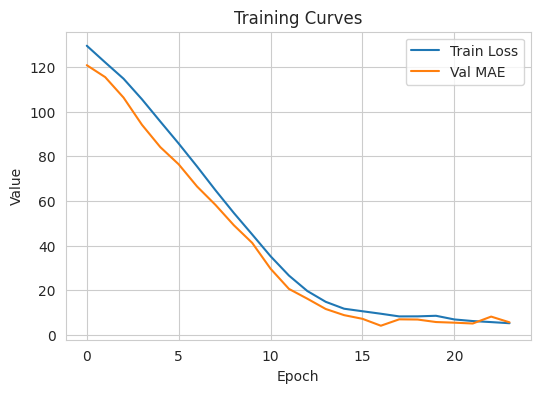

In [35]:
# ==========================================================
# 13) Training Loop with AMP, Early Stopping, Checkpoints
# ==========================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm

# -------- Config --------
PATIENCE = globals().get("PATIENCE", 7)
WARMUP_EPOCHS = warmup_epochs
BASE_LR = 2e-4

best_val_mae = float("inf")
no_improve = 0
history = defaultdict(list)

# -------- AMP scaler --------
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# -------- Checkpoint path (WRITABLE) --------
best_ckpt = "/content/drive/MyDrive/datasets/fabricnet/best_model.pt"

# ==========================================================
# Training Loop
# ==========================================================
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}", leave=False):
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        # ----- Forward + Backward -----
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            preds = model(xb)
            loss = criterion(preds, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_losses.append(loss.item())

    # -------- Validation --------
    model.eval()
    val_abs_error = 0.0
    n_val = 0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                preds = model(xb)

            val_abs_error += torch.abs(preds - yb).sum().item()
            n_val += yb.numel()

    val_mae = val_abs_error / n_val
    train_loss = float(np.mean(train_losses))

    # -------- LR Warmup / Scheduler --------
    if epoch <= WARMUP_EPOCHS:
        lr = BASE_LR * epoch / max(1, WARMUP_EPOCHS)
        for g in optimizer.param_groups:
            g["lr"] = lr
    else:
        scheduler.step()
        lr = optimizer.param_groups[0]["lr"]

    # -------- Logging --------
    history["train_loss"].append(train_loss)
    history["val_mae"].append(val_mae)

    print(
        f"Epoch {epoch:02d}/{EPOCHS} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val MAE: {val_mae:.4f} | "
        f"LR: {lr:.2e}"
    )

    # -------- Early Stopping + Checkpoint --------
    if val_mae < best_val_mae - 1e-4:
        best_val_mae = val_mae
        no_improve = 0
        torch.save(
            {
                "model_state": model.state_dict(),
                "epoch": epoch,
                "val_mae": best_val_mae
            },
            best_ckpt
        )
        print(f"✅ Saved best model (Val MAE = {best_val_mae:.4f})")
    else:
        no_improve += 1
        print(f"No improvement: {no_improve}/{PATIENCE}")

        if no_improve >= PATIENCE:
            print("⏹️ Early stopping triggered.")
            break

# ==========================================================
# Plot Training Curves
# ==========================================================
plt.figure(figsize=(6, 4))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_mae"], label="Val MAE")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Curves")
plt.legend()
plt.grid(True)
plt.show()


✅ Loaded best model from epoch: 17 | Val MAE: 4.009868421052632


/tmp/ipython-input-2609906049.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


📊 Validation Metrics → MAE=4.0099  RMSE=5.4924  R²=0.9827


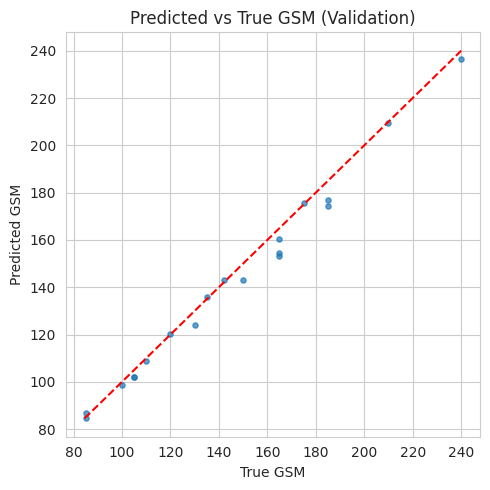

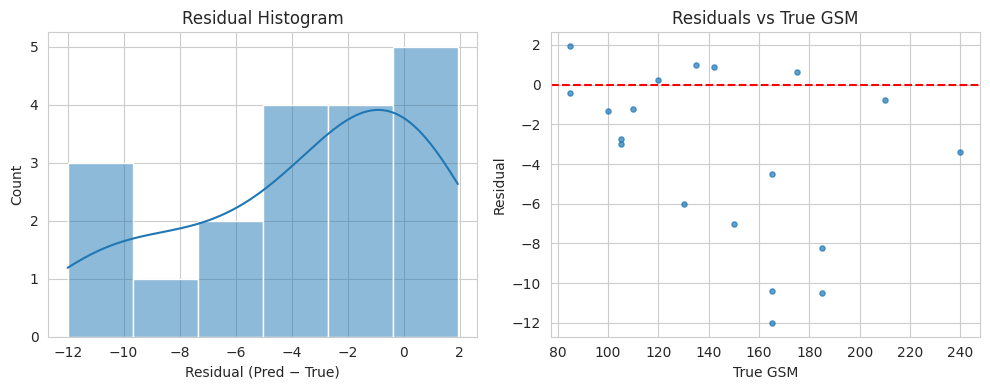

In [37]:
# ==========================================================
# 14) Validation Metrics and Diagnostic Plots (FIXED)
# ==========================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# -------- Load best checkpoint --------
assert os.path.exists(best_ckpt), "Best checkpoint not found"

ckpt = torch.load(best_ckpt, map_location=device)
model.load_state_dict(ckpt["model_state"])
print("✅ Loaded best model from epoch:", ckpt.get("epoch"),
      "| Val MAE:", ckpt.get("val_mae"))

# ==========================================================
# Evaluate on validation set
# ==========================================================

model.eval()
val_preds, val_trues = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            preds = model(xb)

        val_preds.append(preds.cpu())
        val_trues.append(yb.cpu())

val_preds = torch.cat(val_preds)
val_trues = torch.cat(val_trues)

# -------- Metrics (torch-native) --------
mae  = torch.mean(torch.abs(val_preds - val_trues)).item()
rmse = torch.sqrt(torch.mean((val_preds - val_trues) ** 2)).item()

# R²
ss_res = torch.sum((val_trues - val_preds) ** 2)
ss_tot = torch.sum((val_trues - torch.mean(val_trues)) ** 2)
r2 = 1 - ss_res / ss_tot
r2 = r2.item()

print(f"📊 Validation Metrics → MAE={mae:.4f}  RMSE={rmse:.4f}  R²={r2:.4f}")

# ==========================================================
# Diagnostic Plots
# ==========================================================

val_preds_np = val_preds.numpy()
val_trues_np = val_trues.numpy()

# -------- Pred vs True --------
plt.figure(figsize=(5, 5))
plt.scatter(val_trues_np, val_preds_np, s=14, alpha=0.7)
lims = [
    min(val_trues_np.min(), val_preds_np.min()),
    max(val_trues_np.max(), val_preds_np.max())
]
plt.plot(lims, lims, "r--")
plt.xlabel("True GSM")
plt.ylabel("Predicted GSM")
plt.title("Predicted vs True GSM (Validation)")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------- Residual analysis --------
residuals = val_preds_np - val_trues_np

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(residuals, kde=True, ax=axes[0])
axes[0].set_title("Residual Histogram")
axes[0].set_xlabel("Residual (Pred − True)")

axes[1].scatter(val_trues_np, residuals, s=14, alpha=0.7)
axes[1].axhline(0, color="r", linestyle="--")
axes[1].set_xlabel("True GSM")
axes[1].set_ylabel("Residual")
axes[1].set_title("Residuals vs True GSM")

plt.tight_layout()
plt.show()


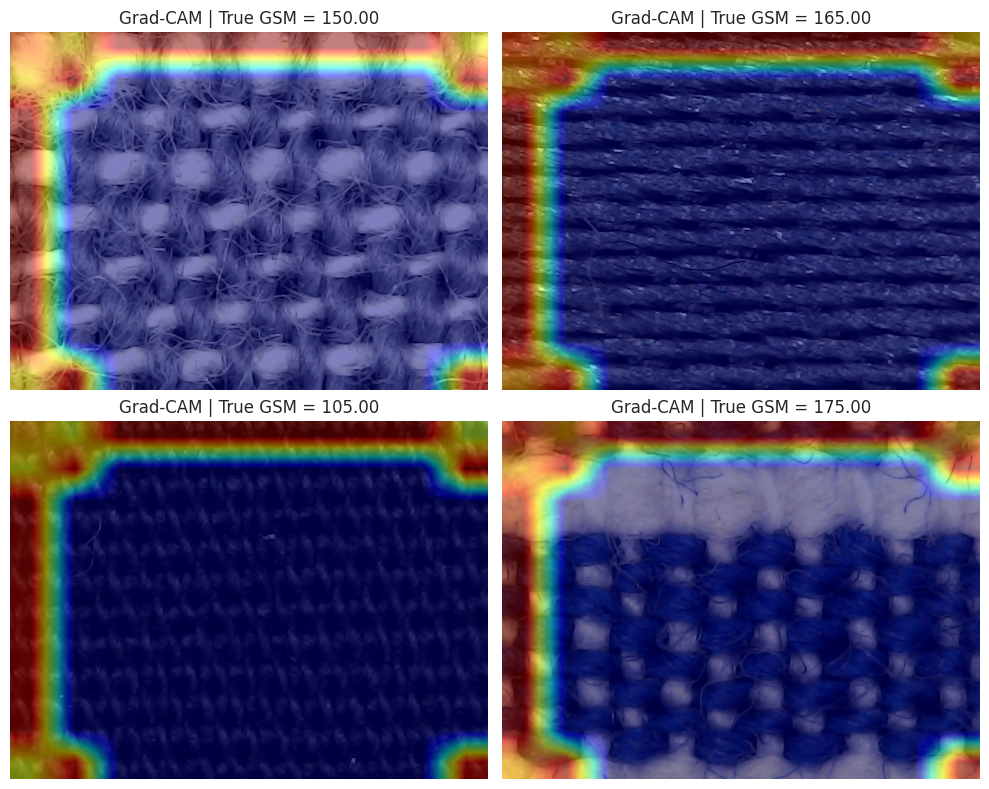

In [39]:
# ==========================================================
# 15) Grad-CAM Visualization (FIXED FOR TIMM MODELS)
# ==========================================================

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ----------------------------------------------------------
# Grad-CAM helper
# ----------------------------------------------------------
def grad_cam_on_image(model, image_np_rgb, target_size=IMG_SIZE):
    model.eval()

    # -------- Preprocess --------
    img = cv2.resize(image_np_rgb, (target_size, target_size))
    img_norm = (img / 255.0 - np.array(IMAGENET_MEAN)) / np.array(IMAGENET_STD)
    tensor = torch.from_numpy(img_norm.transpose(2, 0, 1)) \
                  .float().unsqueeze(0).to(device)
    tensor.requires_grad_(True)

    feats = None
    grads = None

    # -------- Target layer (EfficientNet conv head) --------
    target_layer = model.backbone.conv_head

    def forward_hook(_, __, output):
        nonlocal feats
        feats = output

    def backward_hook(_, grad_input, grad_output):
        nonlocal grads
        grads = grad_output[0]

    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_full_backward_hook(backward_hook)

    # -------- Forward + backward --------
    pred = model(tensor)
    model.zero_grad(set_to_none=True)
    pred.backward(torch.ones_like(pred))

    h1.remove()
    h2.remove()

    if feats is None or grads is None:
        return None

    # -------- Grad-CAM computation --------
    # feats, grads shape: [1, C, H, W]
    weights = grads.mean(dim=(2, 3), keepdim=True)
    cam = (weights * feats).sum(dim=1).squeeze(0)

    cam = cam.detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam /= (cam.max() + 1e-6)

    cam = cv2.resize(cam, (image_np_rgb.shape[1], image_np_rgb.shape[0]))

    heatmap = (plt.cm.jet(cam)[:, :, :3] * 255).astype(np.uint8)
    overlay = (0.5 * image_np_rgb + 0.5 * heatmap).astype(np.uint8)

    return cam, overlay

# ----------------------------------------------------------
# Demo on validation images
# ----------------------------------------------------------
samples = val_df_for_torch.sample(
    min(4, len(val_df_for_torch)), random_state=0
)

plt.figure(figsize=(10, 8))

for i, (_, row) in enumerate(samples.iterrows(), 1):
    img = cv2.imread(row["image_path"])
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = grad_cam_on_image(model, img)

    if result is None:
        continue

    cam, overlay = result

    plt.subplot(2, 2, i)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM | True GSM = {row[TARGET_COL]:.2f}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [41]:
# ==========================================================
# 16) K-Fold Cross-Validation (OPTIONAL, FIXED)
# ==========================================================

from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
from tqdm import tqdm

RUN_KFOLD = False   # 🔁 Set True only if you want to run it
N_SPLITS = 5
KFOLD_EPOCHS = 7

if RUN_KFOLD:

    print(f"🔁 Running {N_SPLITS}-Fold Cross-Validation")

    # Use ORIGINAL (non-augmented) dataset ONLY
    df_kfold = df.reset_index(drop=True)

    # Stratification bins for regression
    bins_all = pd.qcut(
        df_kfold[TARGET_COL],
        q=5,
        labels=False,
        duplicates="drop"
    )

    folds = StratifiedKFold(
        n_splits=N_SPLITS,
        shuffle=True,
        random_state=42
    )

    maes = []

    for fold, (tr_idx, va_idx) in enumerate(folds.split(df_kfold, bins_all), 1):
        print(f"\n🔹 Fold {fold}/{N_SPLITS}")

        tr_df = df_kfold.iloc[tr_idx]
        va_df = df_kfold.iloc[va_idx]

        tr_ds = GSMDataset(tr_df, transform=train_aug_torch)
        va_ds = GSMDataset(va_df, transform=val_aug_torch)

        tr_loader = DataLoader(
            tr_ds,
            batch_size=BATCH_SIZE,
            shuffle=True,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )

        va_loader = DataLoader(
            va_ds,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS,
            pin_memory=True
        )

        # New model per fold
        fold_model = Regressor(backbone_name=BACKBONE).to(device)
        optimizer = torch.optim.AdamW(
            fold_model.parameters(), lr=2e-4, weight_decay=1e-4
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=KFOLD_EPOCHS
        )

        scaler = torch.cuda.amp.GradScaler(
            enabled=torch.cuda.is_available()
        )

        best_fold_mae = float("inf")

        # ---------------- Training ----------------
        for epoch in range(1, KFOLD_EPOCHS + 1):
            fold_model.train()

            for xb, yb in tr_loader:
                xb = xb.to(device, non_blocking=True)
                yb = yb.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)

                with torch.cuda.amp.autocast(
                    enabled=torch.cuda.is_available()
                ):
                    preds = fold_model(xb)
                    loss = criterion(preds, yb)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            scheduler.step()

            # ---------------- Validation ----------------
            fold_model.eval()
            abs_err = 0.0
            n = 0

            with torch.no_grad():
                for xb, yb in va_loader:
                    xb = xb.to(device, non_blocking=True)
                    yb = yb.to(device, non_blocking=True)

                    with torch.cuda.amp.autocast(
                        enabled=torch.cuda.is_available()
                    ):
                        preds = fold_model(xb)

                    abs_err += torch.abs(preds - yb).sum().item()
                    n += yb.numel()

            fold_mae = abs_err / n
            best_fold_mae = min(best_fold_mae, fold_mae)

            print(
                f"Epoch {epoch}/{KFOLD_EPOCHS} | "
                f"Fold MAE: {fold_mae:.4f}"
            )

        maes.append(best_fold_mae)
        print(f"✅ Fold {fold} best MAE: {best_fold_mae:.4f}")

    print("\n📊 K-Fold Results")
    print(f"Mean MAE: {np.mean(maes):.4f}")
    print(f"Std  MAE: {np.std(maes):.4f}")

else:
    print("ℹ️ Set RUN_KFOLD=True to enable K-Fold cross-validation.")


ℹ️ Set RUN_KFOLD=True to enable K-Fold cross-validation.


In [43]:
# ==========================================================
# 17) Final Test Evaluation and Lightweight Unit Tests (FIXED)
# ==========================================================

import os
import numpy as np
import pandas as pd
import torch

# ----------------------------------------------------------
# Unit tests / sanity checks
# ----------------------------------------------------------
a_img, a_lbl = train_ds[0]

assert a_img.ndim == 3 and a_img.shape[0] == 3, "❌ Image tensor shape mismatch"
assert torch.isfinite(a_img).all(), "❌ Non-finite values in image tensor"
assert isinstance(float(a_lbl.item()), float), "❌ Label must be float"

print("✅ Unit tests passed")

# ----------------------------------------------------------
# Test set evaluation
# ----------------------------------------------------------
model.eval()
test_preds, test_trues = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        preds = model(xb)

        test_preds.append(preds.cpu())
        test_trues.append(yb.cpu())

test_preds = torch.cat(test_preds)
test_trues = torch.cat(test_trues)

# ----------------------------------------------------------
# Metrics (torch-native)
# ----------------------------------------------------------
t_mae = torch.mean(torch.abs(test_preds - test_trues)).item()
t_rmse = torch.sqrt(torch.mean((test_preds - test_trues) ** 2)).item()

ss_res = torch.sum((test_trues - test_preds) ** 2)
ss_tot = torch.sum((test_trues - torch.mean(test_trues)) ** 2)
t_r2 = (1 - ss_res / ss_tot).item()

print(f"📊 Test Metrics → MAE={t_mae:.4f}  RMSE={t_rmse:.4f}  R²={t_r2:.4f}")

# ----------------------------------------------------------
# Save test predictions
# ----------------------------------------------------------
OUT_DIR = "/content/drive/MyDrive/datasets/fabricnet/outputs"
os.makedirs(OUT_DIR, exist_ok=True)

TEST_PRED_CSV = os.path.join(OUT_DIR, "test_predictions.csv")

pd.DataFrame({
    "image_path": test_df_for_torch["image_path"].values,
    "true_gsm": test_trues.numpy(),
    "pred_gsm": test_preds.numpy()
}).to_csv(TEST_PRED_CSV, index=False)

print("✅ Wrote:", TEST_PRED_CSV)


✅ Unit tests passed
📊 Test Metrics → MAE=9.6076  RMSE=20.7541  R²=0.7653
✅ Wrote: /content/drive/MyDrive/datasets/fabricnet/outputs/test_predictions.csv


In [45]:
# ==========================================================
# 18) Export Model, Inference Function, Drive Integration
# ==========================================================

import os
import torch
import numpy as np
import cv2

# ----------------------------------------------------------
# Writable output directory (Google Drive)
# ----------------------------------------------------------
DRIVE_ROOT = "/content/drive/MyDrive/gsm_artifacts"
os.makedirs(DRIVE_ROOT, exist_ok=True)

FINAL_MODEL = os.path.join(DRIVE_ROOT, "gsm_regressor.pt")

# ----------------------------------------------------------
# Save final trained model
# ----------------------------------------------------------
assert os.path.exists(best_ckpt), "Best checkpoint not found"

ckpt = torch.load(best_ckpt, map_location=device)
model.load_state_dict(ckpt["model_state"])

torch.save(
    {
        "backbone": BACKBONE,
        "img_size": IMG_SIZE,
        "imagenet_mean": IMAGENET_MEAN,
        "imagenet_std": IMAGENET_STD,
        "model_state": model.state_dict(),
    },
    FINAL_MODEL
)

print("✅ Saved model to:", FINAL_MODEL)

# ----------------------------------------------------------
# Inference utility
# ----------------------------------------------------------
@torch.no_grad()
def predict_image(path: str) -> float:
    model.eval()

    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(path)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

    img = (img / 255.0 - np.array(IMAGENET_MEAN)) / np.array(IMAGENET_STD)
    ten = torch.from_numpy(img.transpose(2, 0, 1)) \
              .float().unsqueeze(0).to(device)

    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
        pred = model(ten)

    return float(pred.squeeze().cpu().item())

# ----------------------------------------------------------
# Demo inference
# ----------------------------------------------------------
print("\n🔍 Demo inference:")
for p in test_df_for_torch["image_path"].sample(
    min(3, len(test_df_for_torch)), random_state=7
):
    pred = predict_image(p)
    print(os.path.basename(p), "→ Pred GSM =", round(pred, 2))

# ----------------------------------------------------------
# Save requirements.txt
# ----------------------------------------------------------
REQ_TXT = os.path.join(DRIVE_ROOT, "requirements.txt")

with open(REQ_TXT, "w") as f:
    f.write("\n".join([
        "torch",
        "torchvision",
        "timm",
        "albumentations",
        "opencv-python-headless",
        "pandas",
        "numpy",
        "matplotlib",
        "seaborn",
        "tqdm",
        "umap-learn",
        "scikit-image"
    ]))

print("✅ Saved requirements to:", REQ_TXT)


✅ Saved model to: /content/drive/MyDrive/gsm_artifacts/gsm_regressor.pt

🔍 Demo inference:


/tmp/ipython-input-1063116136.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


W108.jpg → Pred GSM = 171.5
W075.jpg → Pred GSM = 134.88
W027.jpg → Pred GSM = 107.38
✅ Saved requirements to: /content/drive/MyDrive/gsm_artifacts/requirements.txt


In [47]:
# ==========================================================
# Baseline: Random Forest on Handcrafted Features (FIXED)
# ==========================================================

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# ----------------------------------------------------------
# Build features for train + val (baseline training)
# ----------------------------------------------------------
base_df = pd.concat([X_train, X_val], ignore_index=True)

Xf, yf = [], []
for _, r in tqdm(base_df.iterrows(), total=len(base_df), desc="Baseline features"):
    f = compute_features(r["image_path"])
    if f is not None:
        Xf.append(f)
        yf.append(float(r[TARGET_COL]))

Xf = np.vstack(Xf)
yf = np.array(yf)

# ----------------------------------------------------------
# Random Forest baseline
# ----------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Cross-validation (MAE)
cv = 5
scores = cross_val_score(
    rf,
    Xf,
    yf,
    cv=cv,
    scoring="neg_mean_absolute_error"
)

print(
    f"Baseline RF {cv}-fold MAE: "
    f"{(-scores).mean():.4f} ± {(-scores).std():.4f}"
)

# Train on full train+val
rf.fit(Xf, yf)

# ----------------------------------------------------------
# Evaluate on test set
# ----------------------------------------------------------
Xt, yt = [], []
for _, r in tqdm(X_test.iterrows(), total=len(X_test), desc="Baseline test features"):
    f = compute_features(r["image_path"])
    if f is not None:
        Xt.append(f)
        yt.append(float(r[TARGET_COL]))

Xt = np.vstack(Xt)
yt = np.array(yt)

yp = rf.predict(Xt)

# Metrics (NO squared=False)
test_mae = mean_absolute_error(yt, yp)
test_rmse = np.sqrt(np.mean((yt - yp) ** 2))
test_r2 = r2_score(yt, yp)

print(
    f"Baseline Test → "
    f"MAE={test_mae:.4f}  "
    f"RMSE={test_rmse:.4f}  "
    f"R²={test_r2:.4f}"
)


Baseline features: 100%|██████████| 110/110 [00:04<00:00, 27.50it/s]


Baseline RF 5-fold MAE: 23.7548 ± 3.0899


Baseline test features: 100%|██████████| 20/20 [00:00<00:00, 58.65it/s]

Baseline Test → MAE=22.1512  RMSE=33.0687  R²=0.4041


In [48]:
# 3c) Autodetect CSV, image directory, and key columns (after download)
import glob

# Try to find a CSV under DATA_ROOT
csv_candidates = glob.glob(os.path.join(DATA_ROOT, "**", "*.csv"), recursive=True)
CSV_PATH = csv_candidates[0] if csv_candidates else None
print("Detected CSV:", CSV_PATH)

# Heuristic: find an image directory by scanning for many images
img_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
image_files = [p for p in glob.glob(os.path.join(DATA_ROOT, "**", "*"), recursive=True)
               if os.path.splitext(p)[1].lower() in img_exts]

from collections import Counter
parent_counts = Counter([os.path.dirname(p) for p in image_files])
IMAGE_DIR = None
if parent_counts:
    IMAGE_DIR = max(parent_counts.items(), key=lambda kv: kv[1])[0]
print("Detected IMAGE_DIR:", IMAGE_DIR)

# Detect likely image and target columns
IMAGE_COL = None
TARGET_COL = 'gsm'
ALT_MASS_COL = 'mass'
AREA_COL = 'area_m2'

if CSV_PATH and os.path.exists(CSV_PATH):
    tmp = pd.read_csv(CSV_PATH)
    cols = [c.lower() for c in tmp.columns]
    # Image column heuristic
    for key in ["image", "file", "filename", "path"]:
        matches = [c for c in tmp.columns if key in c.lower()]
        if matches:
            IMAGE_COL = matches[0]
            break
    # Target column heuristic
    gsm_like = [c for c in tmp.columns if "gsm" in c.lower() or "grammage" in c.lower() or "basis" in c.lower()]
    if gsm_like:
        TARGET_COL = gsm_like[0]
    else:
        # mass-like fallback
        mass_like = [c for c in tmp.columns if any(k in c.lower() for k in ["mass","weight","wt"]) ]
        if mass_like:
            ALT_MASS_COL = mass_like[0]
        # area-like fallback
        area_like = [c for c in tmp.columns if "area" in c.lower()]
        if area_like:
            AREA_COL = area_like[0]

print("IMAGE_COL:", IMAGE_COL, "TARGET_COL:", TARGET_COL, "ALT_MASS_COL:", ALT_MASS_COL, "AREA_COL:", AREA_COL)

# Persist detected settings for downstream cells
DETECTED_SETTINGS = {
    'CSV_PATH': CSV_PATH,
    'IMAGE_DIR': IMAGE_DIR,
    'IMAGE_COL': IMAGE_COL,
    'TARGET_COL': TARGET_COL,
    'ALT_MASS_COL': ALT_MASS_COL,
    'AREA_COL': AREA_COL,
}
print("Settings:", DETECTED_SETTINGS)

Detected CSV: None
Detected IMAGE_DIR: /kaggle/input/fabricnet
IMAGE_COL: None TARGET_COL: gsm ALT_MASS_COL: mass AREA_COL: area_m2
Settings: {'CSV_PATH': None, 'IMAGE_DIR': '/kaggle/input/fabricnet', 'IMAGE_COL': None, 'TARGET_COL': 'gsm', 'ALT_MASS_COL': 'mass', 'AREA_COL': 'area_m2'}


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Embeddings:   0%|          | 0/130 [00:00<?, ?it/s]/tmp/ipython-input-3794697704.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Embeddings: 100%|██████████| 130/130 [00:10<00:00, 12.38it/s]
/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


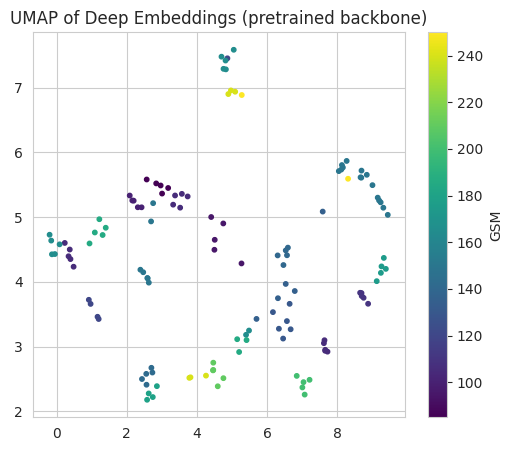

In [49]:
# 10d) Deep Embeddings (timm backbone) + UMAP
# Extract penultimate-layer embeddings from a pretrained backbone and visualize separability
import umap

@torch.no_grad()
def extract_backbone_embeddings(paths, backbone_name='efficientnet_b0'):
    model_fe = timm.create_model(backbone_name, pretrained=True, num_classes=0, global_pool='avg').to(device).eval()
    embs = []
    for p in tqdm(paths, desc='Embeddings'):
        img = cv2.imread(p)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = (img/255.0 - np.array(IMAGENET_MEAN)) / np.array(IMAGENET_STD)
        ten = torch.from_numpy(img.transpose(2,0,1)).float().unsqueeze(0).to(device)
        if torch.cuda.is_available():
            with torch.cuda.amp.autocast():
                f = model_fe(ten)
        else:
            f = model_fe(ten)
        embs.append(f.detach().cpu().numpy())
    if len(embs) == 0:
        return None
    return np.vstack(embs)

subset_deep = df.sample(min(400, len(df)), random_state=7).reset_index(drop=True)
X_deep = extract_backbone_embeddings(subset_deep['image_path'].tolist())
if X_deep is not None:
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embd = reducer.fit_transform(X_deep)
    plt.figure(figsize=(6,5))
    sc = plt.scatter(embd[:,0], embd[:,1], c=subset_deep[TARGET_COL].values[:len(embd)], cmap='viridis', s=10)
    plt.title('UMAP of Deep Embeddings (pretrained backbone)')
    plt.colorbar(sc, label='GSM')
    plt.show()
else:
    print('No embeddings extracted (no readable images).')

In [50]:
# 10e) Inspect Feature Types, Names, and Example Values
# This cell prints the names for each feature we extract and shows sample values.

def get_simple_feature_names(img_size=IMG_SIZE, hist_bins=32):
    names = []
    for c in range(3):
        names += [f"c{c}_mean", f"c{c}_std", f"c{c}_skew"]
    for c in range(3):
        for b in range(hist_bins):
            names.append(f"c{c}_hist_bin{b}")
    names += ["laplacian_var", "sobel_energy"]
    return names

def get_glcm_lbp_feature_names(distances=(1,2,4), angles=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    props = ['contrast','dissimilarity','homogeneity','energy','correlation','ASM']
    names = []
    for p in props:
        for d in distances:
            for a in angles:
                adeg = int(np.rad2deg(a))
                names.append(f"glcm_{p}_d{d}_a{adeg}")
    # LBP histogram bins: P+2 (with P=8 in compute_features_glcm_lbp)
    P = 8
    n_bins = P + 2
    for b in range(n_bins):
        names.append(f"lbp_bin{b}")
    return names

# Print simple feature info
simple_names = get_simple_feature_names()
print(f"Simple features count: {len(simple_names)}")
print("Simple features (first 20):", simple_names[:20], "...")

# Show example values for one image
if len(df) > 0:
    ex_path = df.iloc[0]['image_path']
    fv = compute_features(ex_path)
    if fv is not None:
        print(f"Example simple feature vector length: {len(fv)}")
        for n, v in list(zip(simple_names, fv))[:20]:
            print(f"  {n}: {float(v):.4f}")

# Print texture feature info if available
if 'compute_features_glcm_lbp' in globals() and HAVE_SKIMAGE:
    glcm_lbp_names = get_glcm_lbp_feature_names()
    print(f"GLCM+LBP features count: {len(glcm_lbp_names)}")
    print("GLCM+LBP features (first 20):", glcm_lbp_names[:20], "...")
    if len(df) > 0:
        ex_path = df.iloc[0]['image_path']
        fv2 = compute_features_glcm_lbp(ex_path)
        if fv2 is not None:
            print(f"Example GLCM+LBP feature vector length: {len(fv2)}")
            for n, v in list(zip(glcm_lbp_names, fv2))[:20]:
                print(f"  {n}: {float(v):.4f}")
else:
    print("GLCM/LBP not available; install scikit-image to enable.")

# Deep embedding dimension (from pretrained backbone)
try:
    tmp_backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0, global_pool='avg')
    print("Deep embedding (efficientnet_b0) dim:", tmp_backbone.num_features)
except Exception as e:
    print("Could not inspect deep embedding dim:", e)

# Optional: quick feature importance on simple features
RUN_FEATURE_IMPORTANCE = False
if RUN_FEATURE_IMPORTANCE:
    Xf, yf = [], []
    for _, r in tqdm(df.sample(min(300, len(df)), random_state=0).iterrows(), total=min(300, len(df)), desc='Imp feats'):
        f = compute_features(r['image_path'])
        if f is not None:
            Xf.append(f); yf.append(float(r[TARGET_COL]))
    if Xf:
        from sklearn.ensemble import RandomForestRegressor
        Xf = np.vstack(Xf); yf = np.array(yf)
        rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
        rf.fit(Xf, yf)
        importances = rf.feature_importances_
        idx = np.argsort(importances)[::-1][:20]
        plt.figure(figsize=(8,5))
        plt.barh([simple_names[i] for i in idx][::-1], importances[idx][::-1])
        plt.title('Top-20 Feature Importances (Simple Features)')
        plt.tight_layout(); plt.show()

Simple features count: 107
Simple features (first 20): ['c0_mean', 'c0_std', 'c0_skew', 'c1_mean', 'c1_std', 'c1_skew', 'c2_mean', 'c2_std', 'c2_skew', 'c0_hist_bin0', 'c0_hist_bin1', 'c0_hist_bin2', 'c0_hist_bin3', 'c0_hist_bin4', 'c0_hist_bin5', 'c0_hist_bin6', 'c0_hist_bin7', 'c0_hist_bin8', 'c0_hist_bin9', 'c0_hist_bin10'] ...
Example simple feature vector length: 107
  c0_mean: 180.5494
  c0_std: 80.8199
  c0_skew: -0.7562
  c1_mean: 138.7898
  c1_std: 80.5941
  c1_skew: -0.1092
  c2_mean: 137.9467
  c2_std: 80.0105
  c2_skew: -0.0969
  c0_hist_bin0: 0.0212
  c0_hist_bin1: 0.0144
  c0_hist_bin2: 0.0145
  c0_hist_bin3: 0.0145
  c0_hist_bin4: 0.0150
  c0_hist_bin5: 0.0150
  c0_hist_bin6: 0.0164
  c0_hist_bin7: 0.0168
  c0_hist_bin8: 0.0181
  c0_hist_bin9: 0.0182
  c0_hist_bin10: 0.0186
GLCM/LBP not available; install scikit-image to enable.
Deep embedding (efficientnet_b0) dim: 1280


/tmp/ipython-input-2037931500.py:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


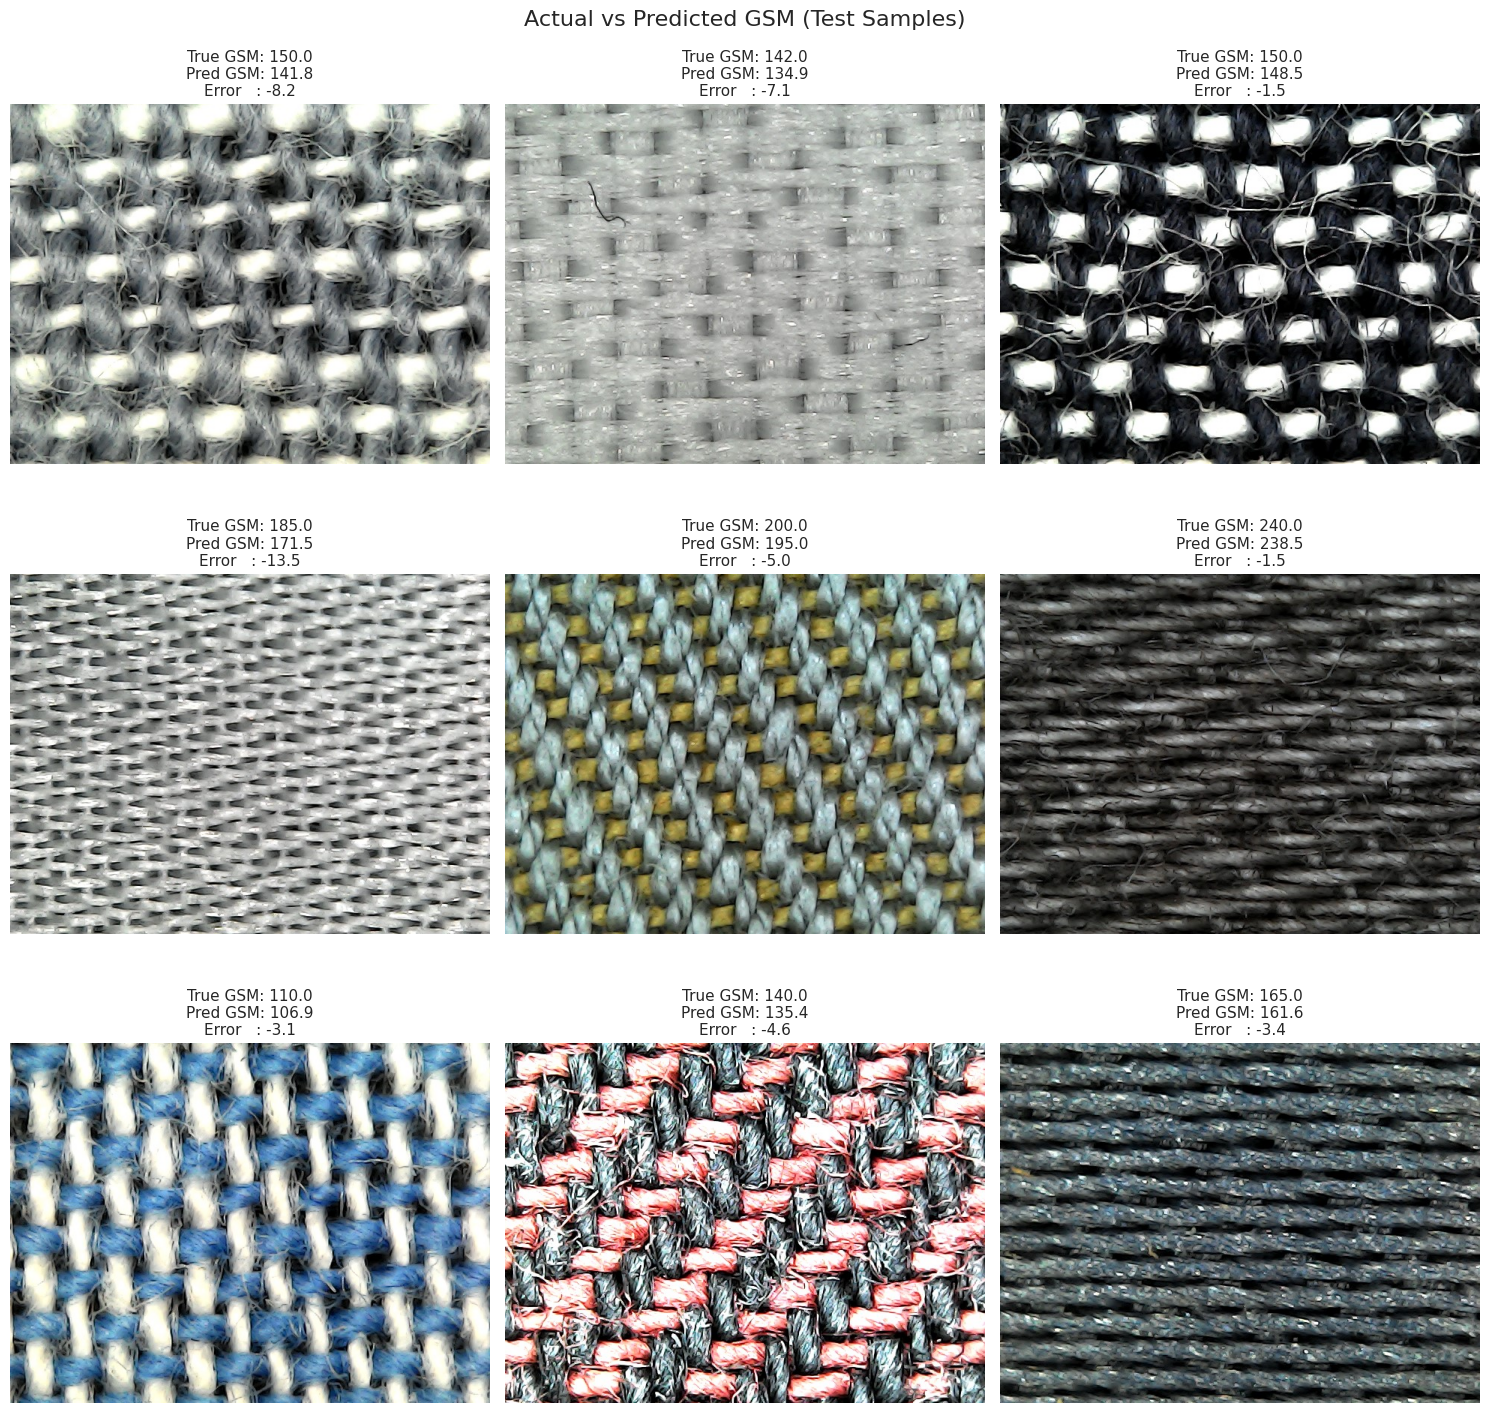

In [51]:
# ==========================================================
# Visualize Actual vs Predicted GSM with Images
# ==========================================================

import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import math

# Number of samples to visualize
N_SAMPLES = min(9, len(test_df_for_torch))

# Sample test images
viz_df = test_df_for_torch.sample(N_SAMPLES, random_state=42).reset_index(drop=True)

model.eval()

cols = 3
rows = math.ceil(N_SAMPLES / cols)
plt.figure(figsize=(5 * cols, 5 * rows))

for i, row in viz_df.iterrows():
    img_path = row["image_path"]
    true_gsm = float(row[TARGET_COL])

    # Load image
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # ---------- Prediction ----------
    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_norm = (img_resized / 255.0 - np.array(IMAGENET_MEAN)) / np.array(IMAGENET_STD)
    ten = torch.from_numpy(img_norm.transpose(2, 0, 1)) \
              .float().unsqueeze(0).to(device)

    with torch.no_grad():
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            pred_gsm = model(ten).item()

    error = pred_gsm - true_gsm

    # ---------- Plot ----------
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis("off")

    title = (
        f"True GSM: {true_gsm:.1f}\n"
        f"Pred GSM: {pred_gsm:.1f}\n"
        f"Error   : {error:+.1f}"
    )
    plt.title(title, fontsize=11)

plt.suptitle("Actual vs Predicted GSM (Test Samples)", fontsize=16)
plt.tight_layout()
plt.show()
